# <center><font color='#3b4859'><u><b>Projet de Scoring : Identifier les clients fragiles</b></u></font></center>

# <font color='#3b4859'><b>L'analyse exploratoire</b></font>


# <font color='#3b4859'>1.Le contexte</font>

Pour ce projet vous vous glisserez dans la peau d’un Data Scientist évoluant dans le domaine de la télécommunication. Vous travaillez au service de l’équipe en charge des actions marketing. Cependant, votre entreprise fait face à un véritable challenge qui est celui d’**identifier les clients fragiles** (susceptibles de résilier leur contrat dans les prochaines périodes) afin de leurs proposer une action de rétention.

Votre mission sera donc d’aider le métier à identifier ces clients fragiles afin de non seulement les fidéliser, mais aussi de permettre à l’entreprise d’économiser de l’argent en ne contactant qu’une partie de la base clientèle.

# <font color='#3b4859'>2. Import des données</font>

In [3]:
# Import de pandas
import pandas as pd

# Import de NumPy
import numpy as np

# Représention graphique
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Typing des fonctions
from typing import List, Optional

# Analyse statistique
import scipy.stats as ss

# Packages scikit-learn pour modélisation
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold, RFECV, SelectKBest, chi2, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Package xgboost
#!pip install xgboost==1.6.2
from xgboost import XGBClassifier

# Package LightGBM
from lightgbm import LGBMClassifier

Import des données des csv.

In [4]:
data1 = "https://raw.githubusercontent.com/alexsavz/projet3DataGong/main/df_telco_customer_churn_demographics.csv"
data2 = "https://raw.githubusercontent.com/alexsavz/projet3DataGong/main/df_telco_customer_churn_services.csv"
data3 = "https://raw.githubusercontent.com/alexsavz/projet3DataGong/main/df_telco_customer_churn_status.csv"

In [5]:
# Conversion des csv en DataFrames
df1 = pd.read_csv(data1, sep=',')
df2 = pd.read_csv(data2, sep=',')
df3 = pd.read_csv(data3, sep=',')

In [6]:
# Affichons les dimensions des DataFrames des données de train

print(f"Données socio-démographiques : {df1.shape[0]} lignes et {df1.shape[1]} colonnes.")
print(f"Données services : {df2.shape[0]} lignes et {df2.shape[1]} colonnes.")
print(f"Données churn : {df3.shape[0]} lignes et {df3.shape[1]} colonnes.")

Données socio-démographiques : 5158 lignes et 8 colonnes.
Données services : 5158 lignes et 28 colonnes.
Données churn : 5158 lignes et 2 colonnes.


In [7]:
# Vérifions les données d'évaluation
eval1 = "https://raw.githubusercontent.com/alexsavz/projet3DataGong/main/eval_df_telco_customer_churn_demographics.csv"
eval2 = "https://raw.githubusercontent.com/alexsavz/projet3DataGong/main/eval_df_telco_customer_churn_services.csv"
eval3 = "https://raw.githubusercontent.com/alexsavz/projet3DataGong/main/eval_df_telco_customer_churn_status_no_target.csv"

df_eval_1 = pd.read_csv(eval1, sep=',')
df_eval_2 = pd.read_csv(eval2, sep=',')
df_eval_3 = pd.read_csv(eval3, sep=',')

print(f"Données socio-démographiques : {df_eval_1.shape[0]} lignes et {df_eval_1.shape[1]} colonnes.")
print(f"Données services : {df_eval_2.shape[0]} lignes et {df_eval_2.shape[1]} colonnes.")
print(f"Données churn : {df_eval_3.shape[0]} lignes et {df_eval_3.shape[1]} colonnes.")

Données socio-démographiques : 1885 lignes et 8 colonnes.
Données services : 1885 lignes et 28 colonnes.
Données churn : 1885 lignes et 1 colonnes.


Affichons les premières lignes des DataFrames des échantillons de train.

In [8]:
df1.head()

,customer_id,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents
0,8779-QRDMV,Male,78,No,Yes,No,No,0
1,1658-BYGOY,Male,71,No,Yes,No,Yes,3
2,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1
3,0390-DCFDQ,Female,76,No,Yes,Yes,Yes,2
4,2656-FMOKZ,Female,70,No,Yes,No,Yes,2


In [9]:
df2.head()

,customer_id,referred_a_friend,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,...,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
0,8779-QRDMV,No,0,1,None,No,0.00,No,Yes,DSL,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,1658-BYGOY,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
2,4846-WHAFZ,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Fiber Optic,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36
3,0390-DCFDQ,Yes,1,1,Offer E,Yes,15.28,No,Yes,Fiber Optic,...,Yes,Month-to-Month,Yes,Mailed Check,70.45,70.45,0.00,0,15.28,85.73
4,2656-FMOKZ,No,0,15,Offer D,Yes,44.07,Yes,Yes,Fiber Optic,...,Yes,Month-to-Month,Yes,Mailed Check,74.45,1145.70,0.00,0,661.05,1806.75


In [10]:
df3.head()

,customer_id,churn_value
0,8779-QRDMV,1
1,1658-BYGOY,1
2,4846-WHAFZ,1
3,0390-DCFDQ,1
4,2656-FMOKZ,1


Nous observons une cohérence de dimensions pour les dataframes sur les échantillons de train et de test.
Nous allons pour la suite de notre exploration réaliser une jointure des données en nous basant sur la clé `costumer_id`.

In [11]:
# Jointure des dataframes
X_train = df1.merge(df2, how='inner', on='customer_id')
X_test = df_eval_1.merge(df_eval_2, how='inner', on='customer_id ')

# Nommage du label
y_train = df3
y_test = df_eval_3

In [12]:
# Affiche les dimensions
print("Dimension des données de train :")
print(f"La matrice de variables explicatives : {X_train.shape}")
print(f"Le vecteur de target : {y_train.shape}\n")

print("Dimension des données de test :")
print(f"La matrice de variables explicatives : {X_test.shape}")
print(f"Le vecteur de target : {y_test.shape}\n")

Dimension des données de train :
La matrice de variables explicatives : (5158, 35)
Le vecteur de target : (5158, 2)

Dimension des données de test :
La matrice de variables explicatives : (1885, 35)
Le vecteur de target : (1885, 1)



Le nouveau DataFrame réuni les données socio-démographiques et les services sans perte d'observations suite à la jointure. Observons les cinq premières lignes.

In [13]:
X_train.head()

,customer_id,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,referred_a_friend,number_of_referrals,...,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
0,8779-QRDMV,Male,78,No,Yes,No,No,0,No,0,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,1658-BYGOY,Male,71,No,Yes,No,Yes,3,No,0,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
2,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,Yes,1,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36
3,0390-DCFDQ,Female,76,No,Yes,Yes,Yes,2,Yes,1,...,Yes,Month-to-Month,Yes,Mailed Check,70.45,70.45,0.00,0,15.28,85.73
4,2656-FMOKZ,Female,70,No,Yes,No,Yes,2,No,0,...,Yes,Month-to-Month,Yes,Mailed Check,74.45,1145.70,0.00,0,661.05,1806.75


# <font color='#3b4859'>3. Exploration du jeu de données</font>

Nous allons ici réaliser l'analyse exploratoire de l'ensemble des données sur l'échantillon de train.

In [14]:
# Dataframe des données initiales, label inclu
df = X_train.merge(df3, how='inner', on='customer_id')

## <font color='#3b4859'>3.1. Description des données</font>


In [15]:
# Affichons les information principales du DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5158 entries, 0 to 5157
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        5158 non-null   object 
 1   gender                             5158 non-null   object 
 2   age                                5158 non-null   int64  
 3   under_30                           5158 non-null   object 
 4   senior_citizen                     5158 non-null   object 
 5   married                            5158 non-null   object 
 6   dependents                         5158 non-null   object 
 7   number_of_dependents               5158 non-null   int64  
 8   referred_a_friend                  5158 non-null   object 
 9   number_of_referrals                5158 non-null   int64  
 10  tenure_in_months                   5158 non-null   int64  
 11  offer                              5158 non-null   objec

Le jeu de données est constitué de :

*   **36 colonnes** avec les thématiques liées à l'ID, la cible, la socio-démographie, les services
*   **5158 observations**, respectivement les clients
*   12 variables numériques et 23 catégorielles
*   Aucune valeurs manquantes
*   3 types de données, float64(6), int64(7), object(23)




### Variables numériques
'age', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges', 'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue'

### Variables catégorielles
'customer_id', 'gender', 'under_30', 'senior_citizen', 'married', 'dependents', 'referred_a_friend', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method'

In [16]:
categoricals = df.select_dtypes(include='object').columns.tolist()
df[['internet_service', 'internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv']].describe()

,internet_service,internet_type,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv
count,5158,5158,5158,5158,5158,5158,5158
unique,2,4,2,2,2,2,2
top,Yes,Fiber Optic,No,No,No,No,No
freq,4051,2229,3684,3384,3412,3675,3186


## <font color='#3b4859'>3.2. Contrôle de la qualité des données</font>

### <font color='#3b4859'>3.2.1 Recherche de valeurs manquantes</font>



Le jeu de données ne présente pas de valeurs manquantes comme indiqué dans la description.

In [17]:
# Valeurs manquantes
missing_values = df.isna().sum().sum()
print(f"Nombre de valeurs manquantes : {missing_values}.")

Nombre de valeurs manquantes : 0.


In [18]:
missing_values = X_test.isna().sum().sum()
print(f"Nombre de valeurs manquantes dans l'échantillon de test: {missing_values}.")

Nombre de valeurs manquantes dans l'échantillon de test: 0.


### <font color='#3b4859'>3.2.2 Recherche de valeurs aberrentes</font>

Nous utiliserons pour ces données la méthode de l'Inter-Quartile Range (IQR).

In [19]:
# Création d'une fontion pour détecter les outliers dans un DataFrame
def detect_possible_outliers(df, column):
    """
    Détecte les outliers dans une colonne numérique d'un DataFrame selon la méthode de l'IQR.

    Inputs :
    --------
    - df : DataFrame
    - column : Nom de la colonne numérique (str)

    Outputs :
    ---------
    Renvoie la liste des index des possibles outliers ainsi que les limites basse et haute

    """

    # 1er Quartile
    Q1 = np.nanpercentile(df[column], 25)

    # 3ème Quartile
    Q3 = np.nanpercentile(df[column], 75)

    # Inter-Quartile Range (IQR)
    IQR = Q3 - Q1

    # limites, basse & haute
    outer_fence = IQR * 1.5
    outer_lower = Q1 - outer_fence
    outer_upper = Q3 + outer_fence

    # Détection des outliers potentiels
    mask = (df[column] < outer_lower) | (df[column] > outer_upper)

    # Stockage de leurs indices
    possible_outlier_index = df[mask].index

    # Passage sous forme de list
    outliers_index = possible_outlier_index.tolist()

    return sorted(outliers_index), outer_lower, outer_upper


# Affichage des index
numerical_features = df.select_dtypes(include="number").columns.tolist()
num_possible_outlier = []
for column in numerical_features:
  outliers_index, outer_lower, outer_upper = detect_possible_outliers(df, column)
  num_possible_outlier.append({
      "column" : column,
      "outliers" : len(outliers_index),
      "lower" : outer_lower,
      "upper" : outer_upper})
df_possible_outlier = pd.DataFrame(data=num_possible_outlier)
df_possible_outlier
#print(f"Les potentiels outliers (valeurs supérieures à {outer_upper} / inférieures à {outer_lower}) sont aux index :\n{outliers_index}")

,column,outliers,lower,upper
0,age,0,-10.00000,102.00000
1,number_of_dependents,1181,0.00000,0.00000
2,number_of_referrals,486,-4.50000,7.50000
3,tenure_in_months,0,-60.00000,124.00000
4,avg_monthly_long_distance_charges,0,-31.82625,76.96375
5,avg_monthly_gb_download,267,-30.50000,61.50000
6,monthly_charge,0,-45.08125,170.46875
7,total_charges,0,-4686.76250,8843.93750
8,total_refunds,387,0.00000,0.00000
9,total_extra_data_charges,545,0.00000,0.00000


In [20]:
# Total de possibles ouliers
df_possible_outlier['outliers'].sum()

3033

Affichons la description des données des variables numériques.

In [21]:
outliers_col = df_possible_outlier['column'].values
df[outliers_col].describe()

,age,number_of_dependents,number_of_referrals,tenure_in_months,avg_monthly_long_distance_charges,avg_monthly_gb_download,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,churn_value
count,5158.000000,5158.000000,5158.000000,5158.000000,5158.000000,5158.000000,5158.000000,5158.000000,5158.000000,5158.000000,5158.000000,5158.000000,5158.000000
mean,46.466848,0.462389,1.918767,32.205312,22.684093,20.671578,64.655719,2265.517156,1.979810,6.843738,736.574139,3006.955223,0.263474
std,16.692835,0.953261,2.983276,24.571588,15.418892,20.506272,29.910190,2259.890674,7.935438,25.010434,840.958661,2854.210756,0.440560
min,19.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.250000,18.850000,0.000000,0.000000,0.000000,21.360000,0.000000
25%,32.000000,0.000000,0.000000,9.000000,8.970000,4.000000,35.750000,387.250000,0.000000,0.000000,64.762500,595.522500,0.000000
50%,46.000000,0.000000,0.000000,29.000000,22.395000,17.000000,70.325000,1383.250000,0.000000,0.000000,387.815000,2074.630000,0.000000
75%,60.000000,0.000000,3.000000,55.000000,36.167500,27.000000,89.637500,3769.925000,0.000000,0.000000,1176.920000,4756.977500,1.000000
max,80.000000,9.000000,11.000000,72.000000,49.990000,85.000000,118.750000,8672.450000,49.760000,150.000000,3564.000000,11979.340000,1.000000


Affichons, sous forme de boîte à moustache, les colonnes avec des outliers pour mieux les visualiser.

In [22]:
outliers_col = df_possible_outlier[df_possible_outlier['outliers'] > 0]
print(f"La méthode IQR nous permet de détecter {len(outliers_col)} colonnes avec de possibles outliers.")

La méthode IQR nous permet de détecter 7 colonnes avec de possibles outliers.


<Axes: >

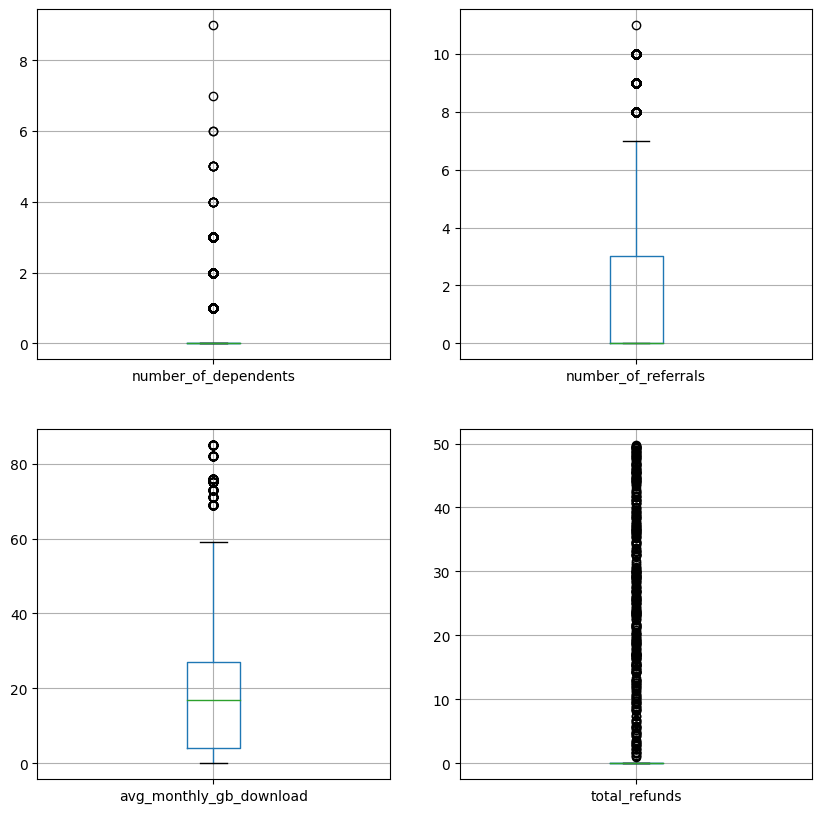

In [23]:
# colonnes avec des outliers
outliers_col = outliers_col['column'].tolist()

# Représentation graphique avec des box plots
fig, (axs) = plt.subplots(2, 2, figsize=(10, 10))
df.boxplot(column=outliers_col[0], ax=axs[0,0])
df.boxplot(column=outliers_col[1], ax=axs[0,1])
df.boxplot(column=outliers_col[2], ax=axs[1,0])
df.boxplot(column=outliers_col[3], ax=axs[1,1])


<Axes: >

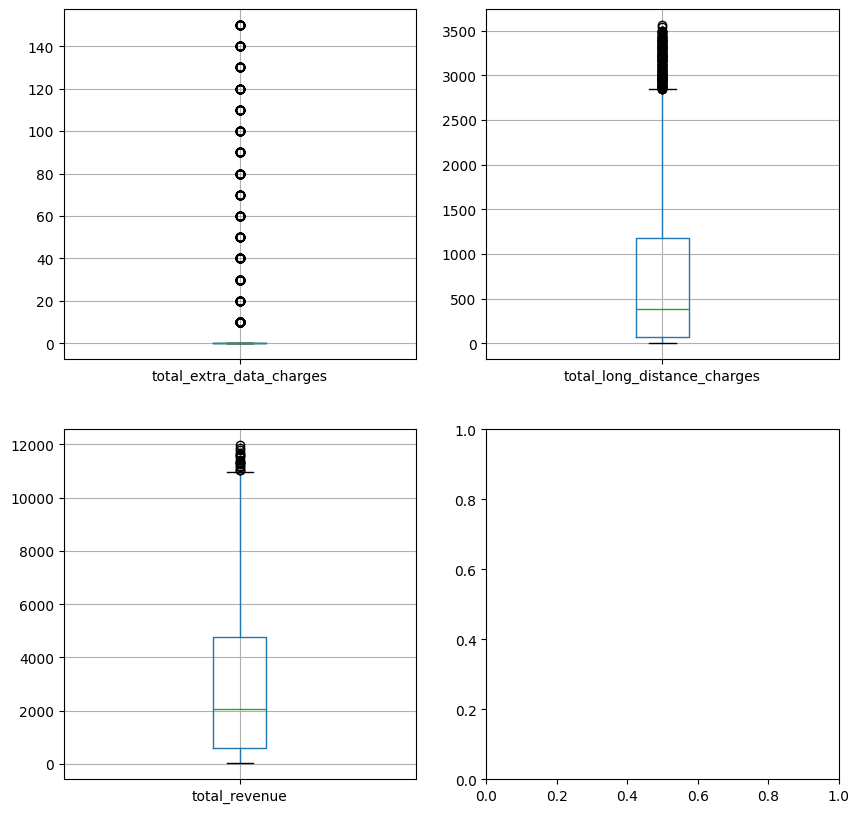

In [24]:
fig, (axs) = plt.subplots(2, 2, figsize=(10, 10))
df.boxplot(column=outliers_col[4], ax=axs[0,0])
df.boxplot(column=outliers_col[5], ax=axs[0,1])
df.boxplot(column=outliers_col[6], ax=axs[1,0])

Nous serons proprablement amené dans la suite de cette étude à corriger les outliers, à la condition que ces variables soient pertinentes et utilisées dans notre modèle prédictif.

Par ailleurs, d'un point de vue métier toutes ces données sont possibles. La seule correction qui serait à faire sur les outliers aurait pour objectif d'améliorer les performances du modèle.

### <font color='#3b4859'>3.2.3 Recherche de valeurs dupliquées</font>

In [25]:
# Recherche des lignes intégralement dupliquées
print(f"Nous observons {df.duplicated(keep=False).sum()} lignes dupliquées")

Nous observons 0 lignes dupliquées


In [26]:
# lignes dupliquées sur l'échantillon de test
print(f"Nous observons {X_test.duplicated(keep=False).sum()} lignes dupliquées dans l'échantillon de test.")

Nous observons 0 lignes dupliquées dans l'échantillon de test.


### <font color='#3b4859'>3.2.4 Feature engineering</font>

Nous pouvons regrouper les variables catégorielles qui concernent une option (`'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data'`) pour les réduires sur une seule variables numérique.

In [27]:
options = ['online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']
def options_number(row):
  i = 0
  for col in options:
    if row[col] == "Yes":
      i += 1
    else:
      i += 0
  return i

X_train["options_number"] = X_train[options].apply(lambda x: options_number(x), axis = 1)

In [28]:
df["options_number"] = X_train["options_number"]

In [29]:
X_train["options_number"]

0       2
1       4
2       1
3       1
4       1
       ..
5153    1
5154    2
5155    0
5156    7
5157    7
Name: options_number, Length: 5158, dtype: int64

### Réduction de dimension

In [30]:
# Recherchons les variables catégorielles qui se seraient susceptibles d'être réduites

cat_nunique = X_train.select_dtypes(include='object').nunique()
more_than_two = [print(f"Colonne : {index}, nunique : {value}") for index, value in cat_nunique.items() if value > 2]

Colonne : customer_id, nunique : 5158
Colonne : offer, nunique : 6
Colonne : internet_type, nunique : 4
Colonne : contract, nunique : 3
Colonne : payment_method, nunique : 3


In [31]:
mask = X_train["offer"].unique()
for index in mask:
  print(index, X_train["offer"][X_train["offer"] == index].count())

None 2848
Offer D 445
Offer C 310
Offer E 597
Offer B 590
Offer A 368


## <font color='#3b4859'>3.3. Analyse exploratoire</font>

Définissons pour la suite du projet des variables en fonction du type des données ; numériques ou catégorielles.

In [32]:
# Création des listes de variables par type de données
cat_cols = X_train.select_dtypes(include='object').columns.tolist()
num_cols = X_train.select_dtypes(include='number').columns.tolist()
all_cols = X_train.columns.tolist()

print(f"La liste des {len(cat_cols)} colonnes catégorielles :\n{cat_cols}\n")
print(f"La liste des {len(num_cols)} colonnes numériques :\n{num_cols}\n")
print(f"La liste des {len(all_cols)} colonnes :\n{all_cols}")

La liste des 23 colonnes catégorielles :
['customer_id', 'gender', 'under_30', 'senior_citizen', 'married', 'dependents', 'referred_a_friend', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method']

La liste des 13 colonnes numériques :
['age', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges', 'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue', 'options_number']

La liste des 36 colonnes :
['customer_id', 'gender', 'age', 'under_30', 'senior_citizen', 'married', 'dependents', 'number_of_dependents', 'referred_a_friend', 'number_of_referrals', 'tenure_in_months', 'offer', 'phone_service', 'avg_monthly

###<font color='#3b4859'>3.3.1 Distribution de la variable cible</font>

In [33]:
# Affichons la distribution de churn_value
target_distribution = (pd.DataFrame(y_train['churn_value'].value_counts(normalize=True) * 100)
                       .reset_index()
                       .rename(columns={"index": "churn_value", "churn_value": "count"})
                      )
target_distribution

,churn_value,count
0,0,73.652579
1,1,26.347421


### Représentation graphique de la distribution des clients churn

Text(0.5, 1.0, 'Distribution  de la variable cible')

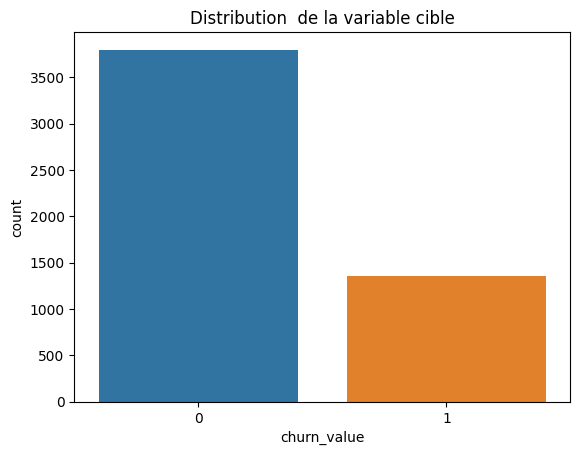

In [34]:
sns.countplot(x=y_train["churn_value"]).set_title("Distribution  de la variable cible")

In [35]:
fig = px.bar(target_distribution, x='count', y='churn_value', orientation='h')
fig.show()

74% des clients ont conservé leur contrat.

### <font color='#3b4859'>3.3.2 Liaisons entre variables explicatives et target</font>

### <font color='#3b4859'>Varbiables numériques et target</font>

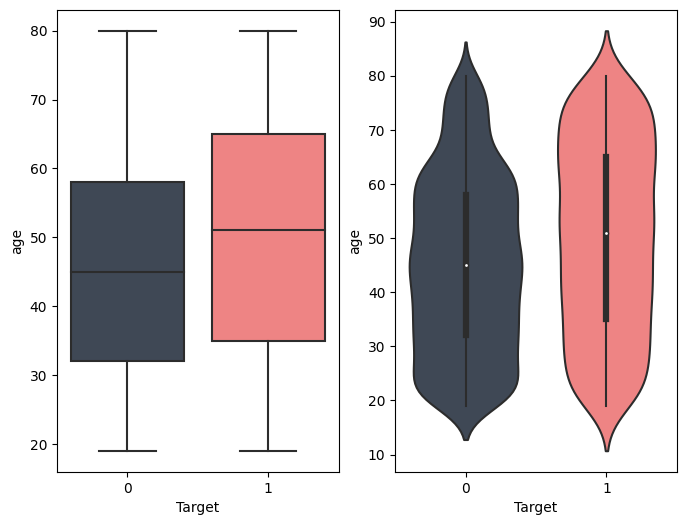

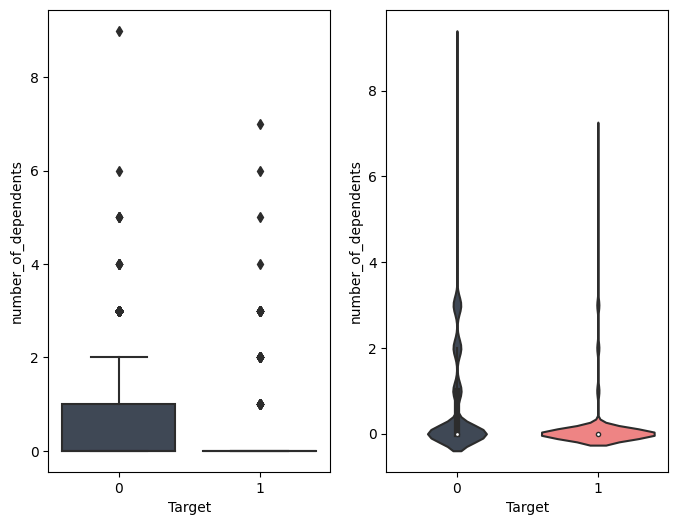

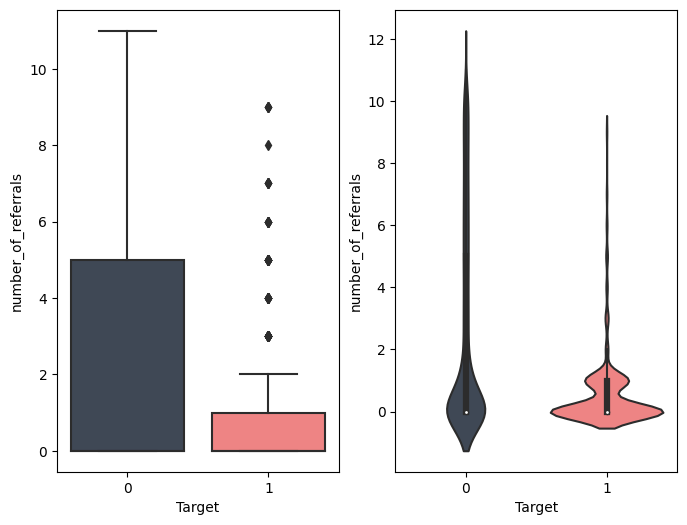

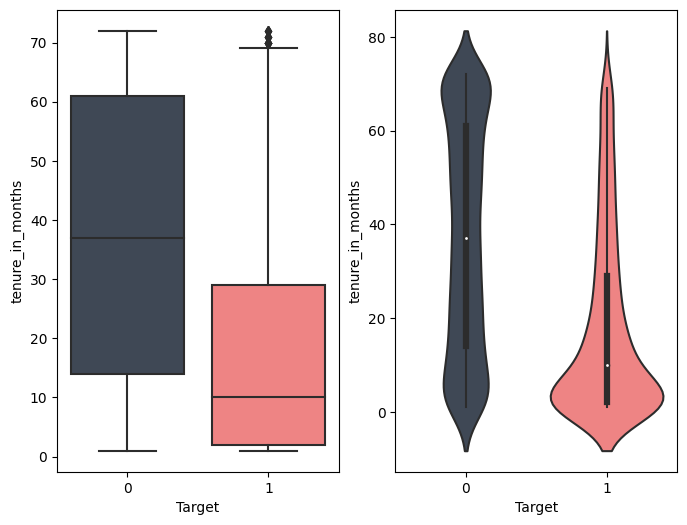

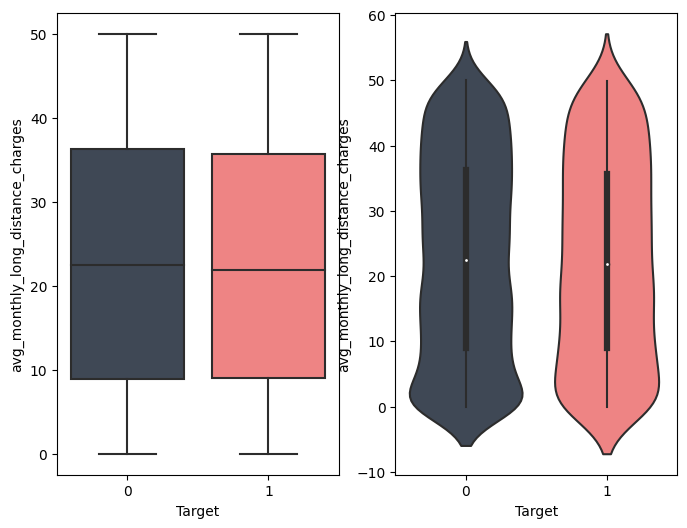

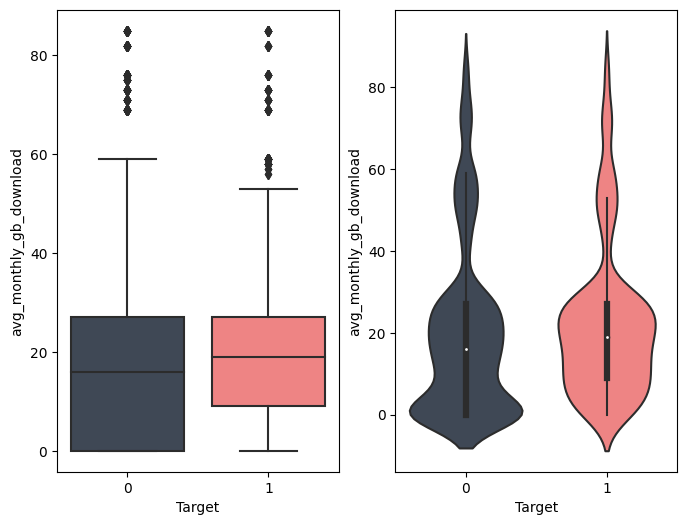

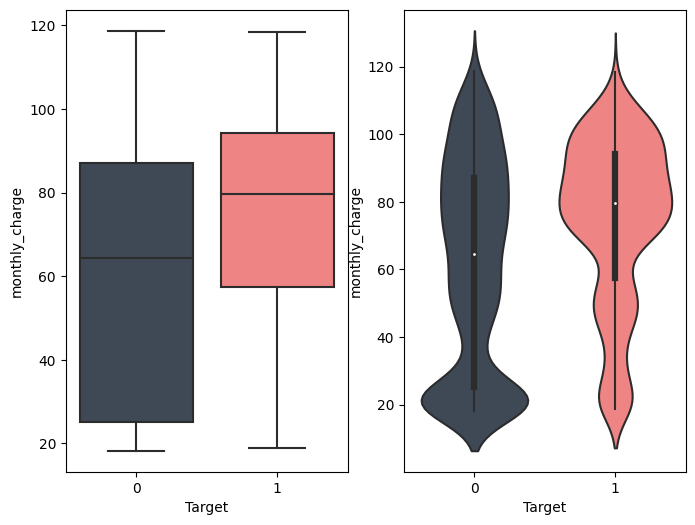

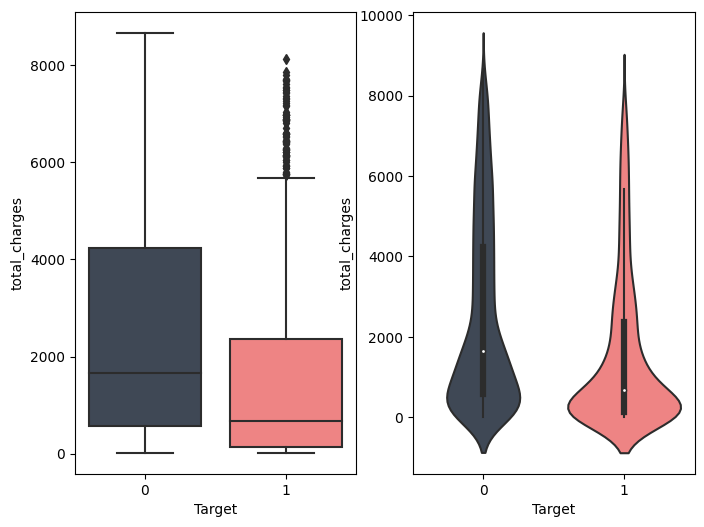

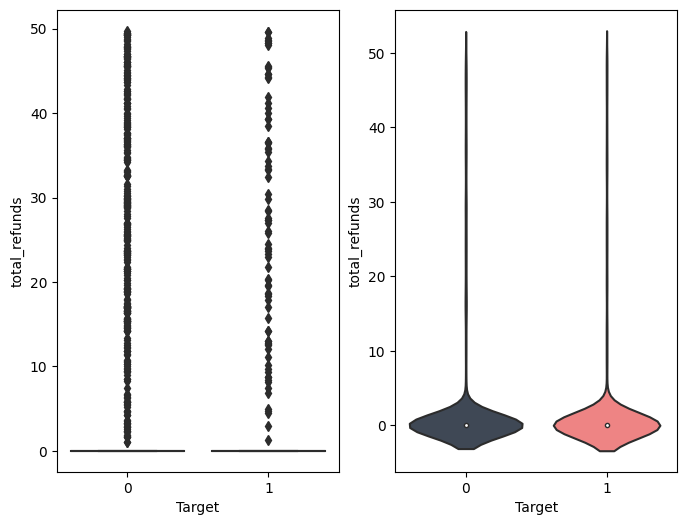

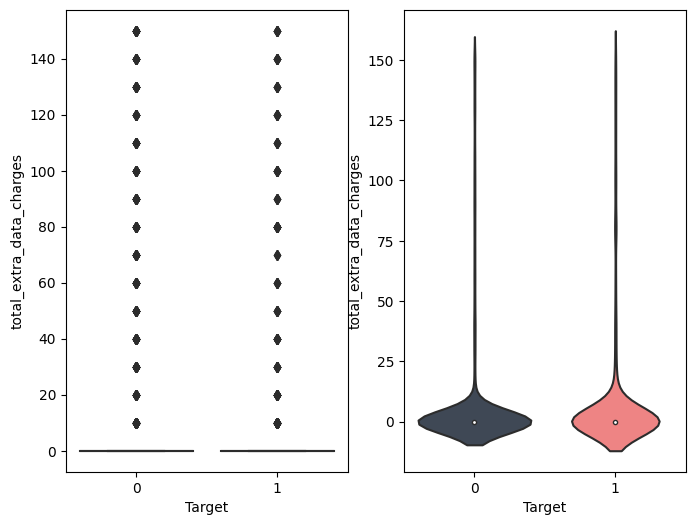

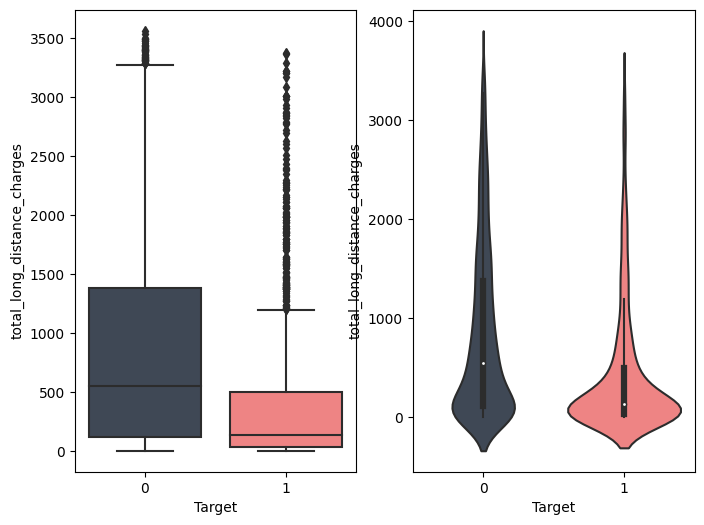

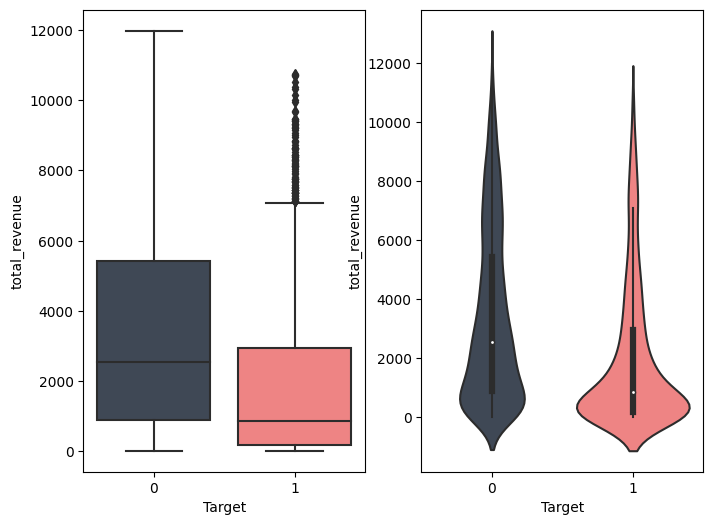

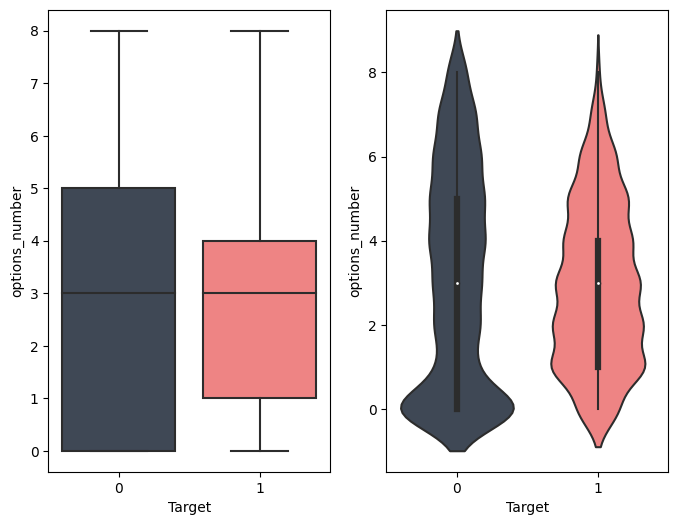

In [36]:
# Représentation graphique des variables numériques en fonction de la target
for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    # Boxplot entre la target et la variable explicative col
    sns.boxplot(x=y_train["churn_value"], y=X_train[col], ax=ax[0], palette=["#3b4859", "#ff7373"])
    ax[0].set_xlabel('Target')
    # Pour le violinplot entre la target et la variable explicative col
    # Procédez comme avec le boxplot
    sns.violinplot(x=y_train["churn_value"], y=X_train[col], ax=ax[1], palette=["#3b4859", "#ff7373"])
    ax[1].set_xlabel('Target')

Ce que l'on peut dire de ces graphiques sur la tendance à accepter l'offre:

*   Les clients les plus anciens sont plus appétents. Surtout après 30 mois.
*   Le prix de l'abonnement est un facteur de résiliation. Moyenne de 80€ pour les résiliations.
*   Plus le client est engagé économiquement avec l'opérateur plus il a de chance de rester. A l'inverse les clients peu engagés économiquement, avec moins de 2000€ de dépense au total, sont enclins à résilier.
*   Les clients avec un revenu inférieur à 3000€ et en moyenne de 1500€ résilient plus.

Au regard de ces variables, le facteur économique et l'ancienneté sont les facteurs prédominants.



### <font color='#3b4859'>Varbiables catégorielles et target</font>

In [37]:
# Séléctionnons les variables catégorielles sauf l'ID
cat_cols = cat_cols[1:]

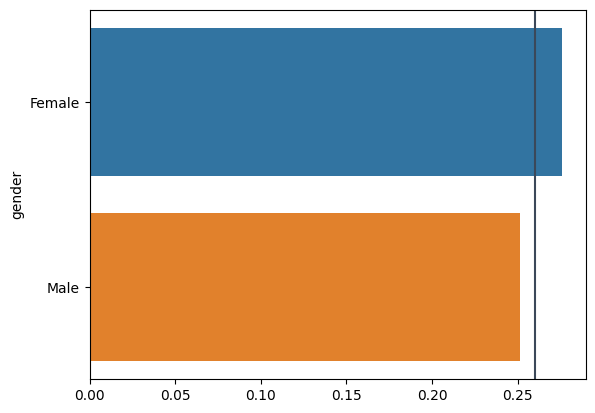

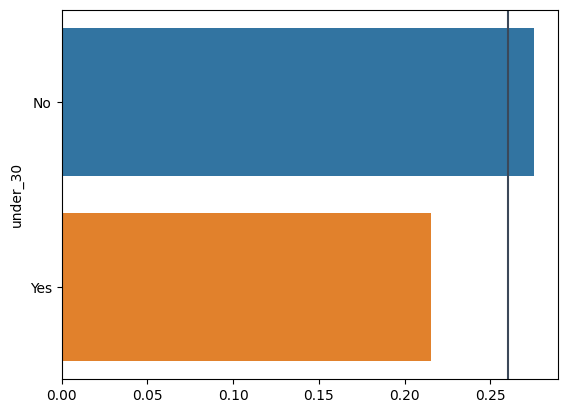

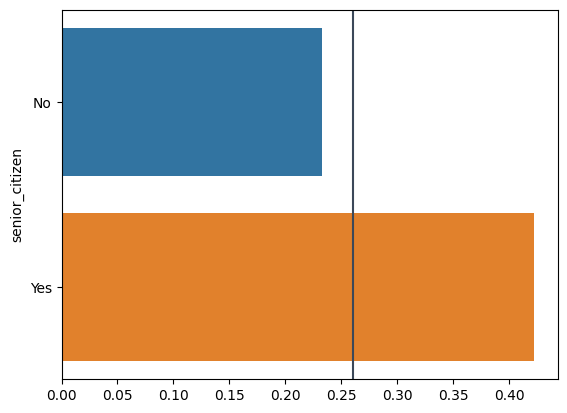

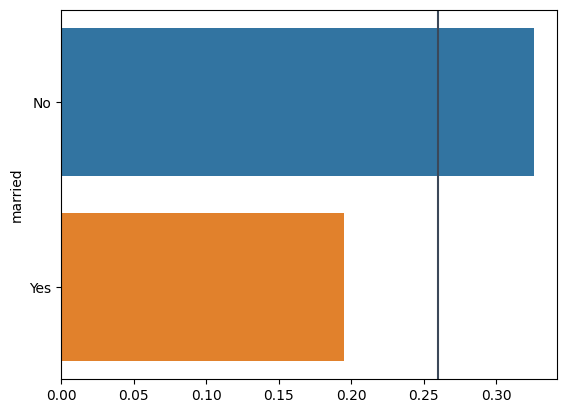

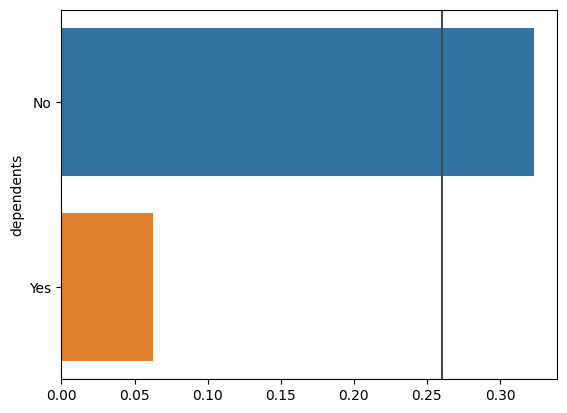

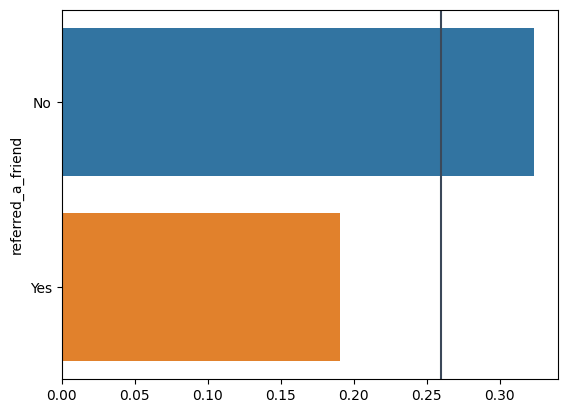

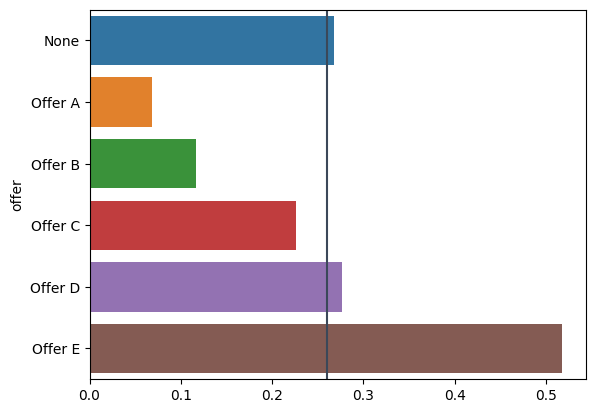

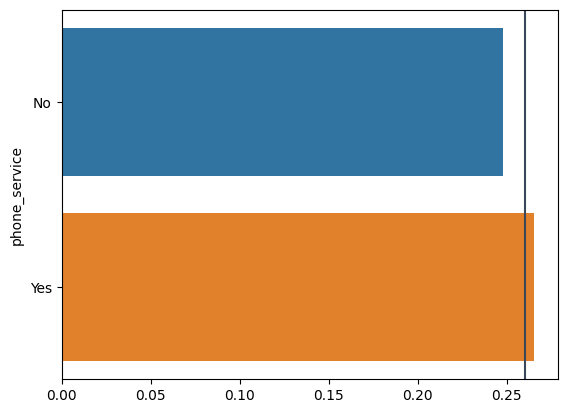

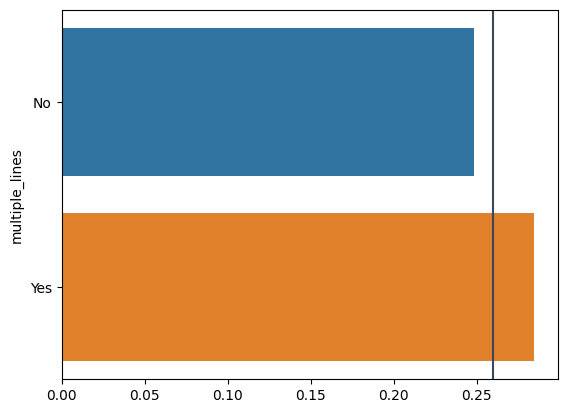

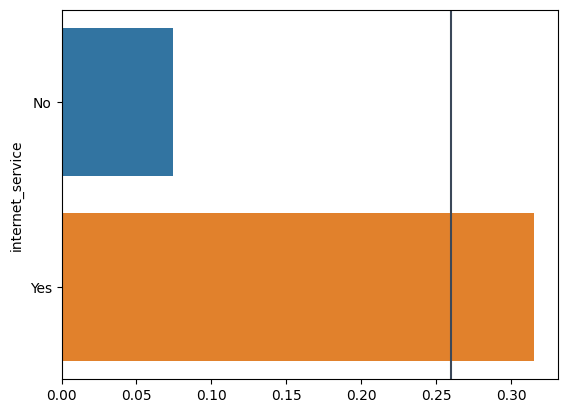

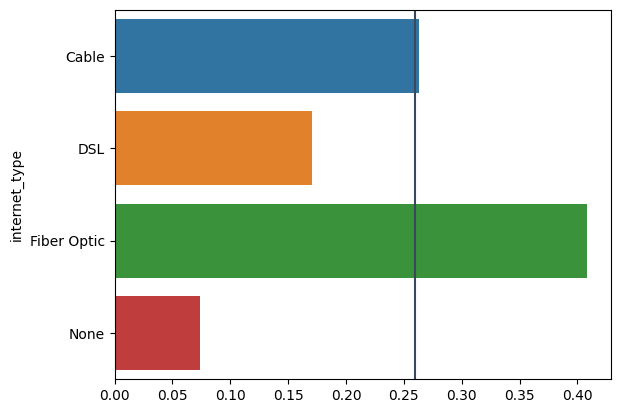

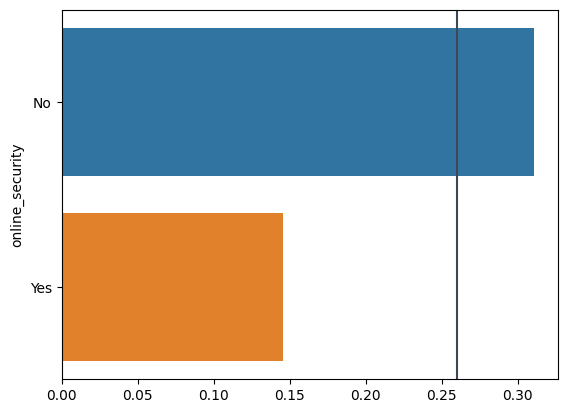

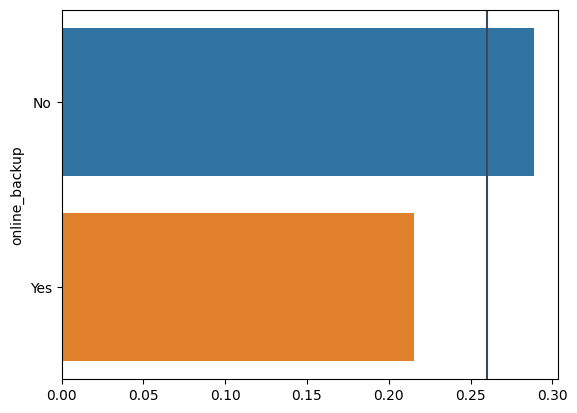

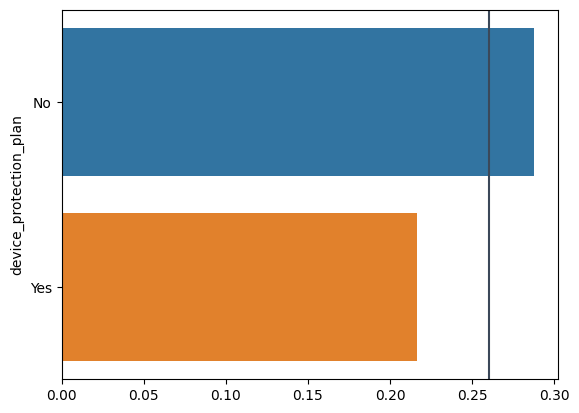

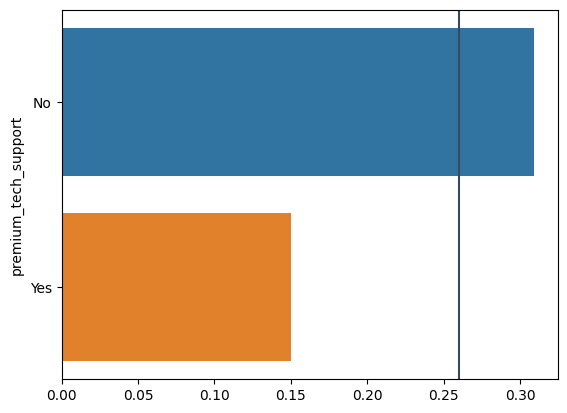

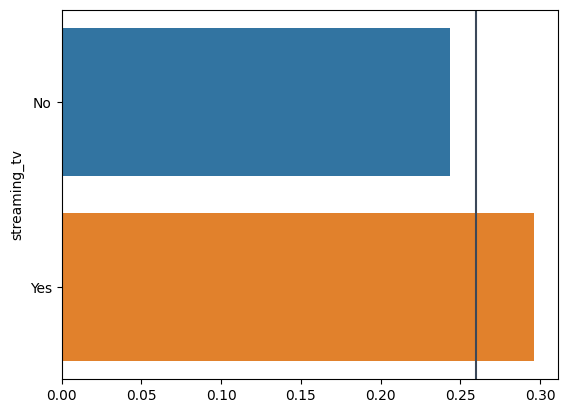

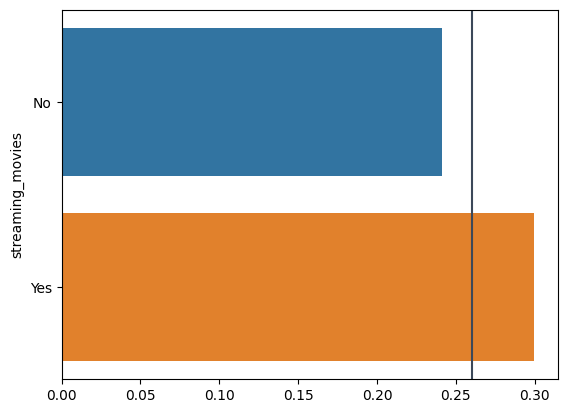

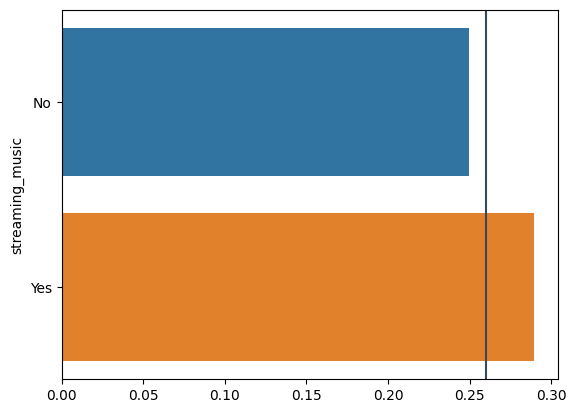

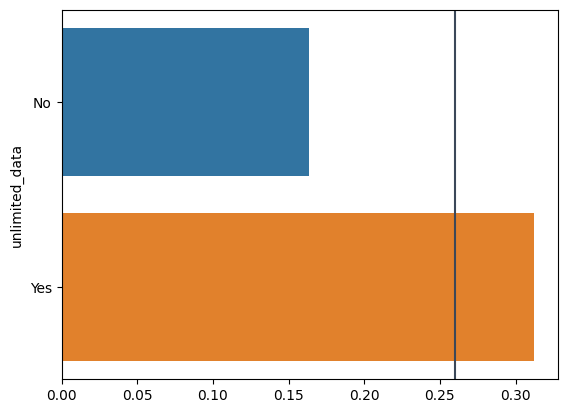

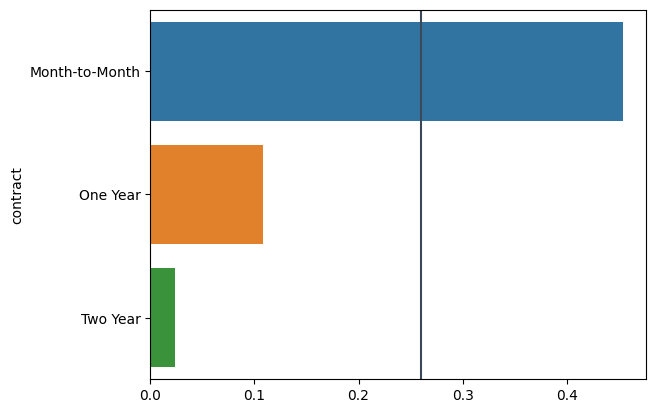

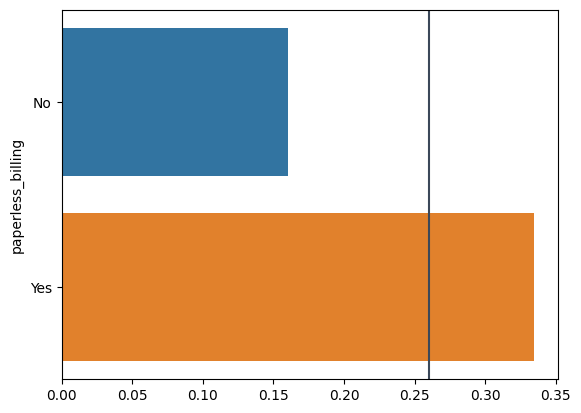

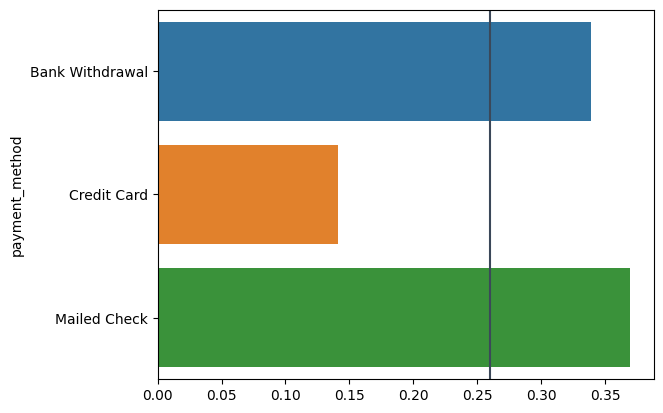

In [38]:
# Représentation graphique pour variables catégorielles
for col in cat_cols:
    # Construction tableau de contingence
    df_crosstab = (pd.crosstab(index=X_train[col],
                               columns=y_train["churn_value"],
                               normalize="index")
                  )
    df_crosstab.reset_index(drop=False, inplace=True)

    # Représentation graphique
    plt.figure()
    bar_plot = sns.barplot(df_crosstab, x=df_crosstab[1], y=df_crosstab[col])
    bar_plot.axvline(0.26, color="#3b4859") # Taux de cible
    bar_plot.set(xlabel='')
    plt.show()

Sur chacun des graphiques si dessus, la droite verticale bleu indique le taux de cible de la résiliation dans la population de l'échantillon.

Ceci nous permet de tirer des observations sur l'influence d'une variable sur le fait de résilier un abonnement.

Ce que l'on peut analyser :

*   `senior_citizen` les personnes agées de plus de 65 ont plus résiliés.
*   `dependents` les clients vivant seuls sont très enclins à résilier.
*   `offer` l'offre E est la plus résilié contrairement à la A.
*   `contract` les abonnement mensuels fidélisent moins (environ 40% des résiliations)
*   `internet_service` les clients sans offre internet ont très peu résilié



### <font color='#3b4859'>3.3.2 Liaisons entre variables explicatives</font>

### <font color='#3b4859'>Variables numériques et matrice des corrélations</font>

Nous allons ici étudier l'interdépendance des variables numériques. La force de liaison entre deux variables est calculée par le coefficient de pearson.
Nous afficherons ensuite une heatmap des scores compris entre -1 et 1, la liaison maximale étant de 1.

Cette étape nous donne des indications pour la suite de notre étude et la construction du modèle. Nous séléctionnerons les variables les plus pertinentes pour le scoring.

C:\Users\alexs\AppData\Local\Temp\ipykernel_33640\4163436445.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

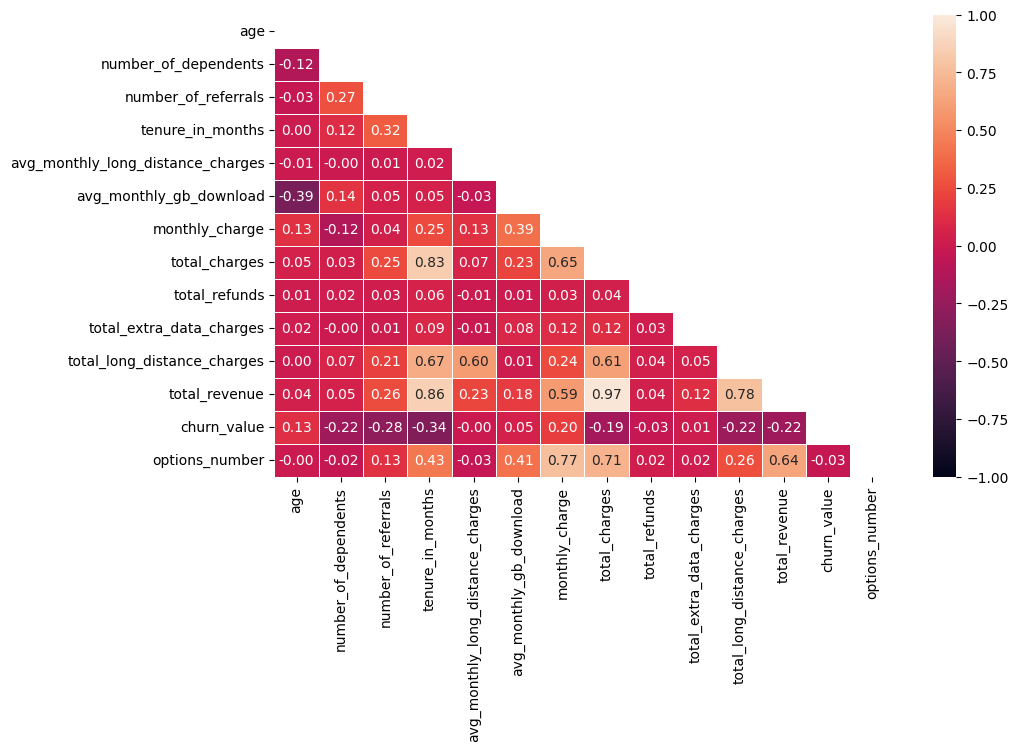

In [39]:
# Matrice de corrélation sur le train dataset (X_train)
pearson_matrix = df.corr()

# Filtre sur le matrice triangulaire inférieure
mask = np.triu(np.ones_like(pearson_matrix))

# Visualisation de la matrice de corrélation
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pearson_matrix, vmin=-1, vmax=1, mask=mask, annot=True, linewidths=.5, fmt=".2f", ax=ax)

Peu de variables présentent un risque de colinéarité. La liaison la plus importante (97%) se situe entre `total_charges` et `total_revenue`.

### <font color='#3b4859'>Variables catégorielles et V de cramer</font>

In [40]:
#@title fonction de calcul du V de Cramer
# Charger la fonction du calcul de V de Cramer pour un dataframe
# calcul V de Cramer pour deux variables
def cramer_v_coeff(x: List, y: List) -> float:
    """Cette fonction permet de calculer le V de
    Cramer entre deux varaibles catégorielles.

    Args:
        x : Le vecteur de variable x.
        y : Le vecteur de variable y.

    Returns:
        float: La valeur V de cramer.
    """

    # Calcul du Khi-deux max (dénomimateur du V de Cramer)
    n = len(x)
    khi2_max = n * min(len(x.value_counts()), len(y.value_counts())) - 1

    # Calcul du khi-deux (numérateur du V de Cramer)
    conf_matrix = pd.crosstab(x, y)
    khi2 = ss.chi2_contingency(observed=conf_matrix, correction=True)

    # Calcul V de Cramer et récupération p_value associée
    cramer = round(np.sqrt(khi2[0] / khi2_max), 4)
    p_value = khi2[1]

    return cramer, p_value


# calcul V de Cramer pour un dataframe
def compute_cramer_v(data: pd.DataFrame) -> pd.DataFrame:
        """Calculer le V de cramer pour un dataframe.

        Args:
            data: Jeu de données sur lequel on souhaite
            calculer le V de Cramer.

        Returns:
            DataFrame contenant les différents V de Cramer.
        """
        ncols = data.shape[1]
        cols = data.columns
        cramer_matrix = np.eye(ncols)
        for j in range(ncols - 1):
            for i in range(j + 1, ncols):
                cramer_matrix[[i, j], [j, i]] = cramer_v_coeff(
                    x=data.iloc[:, j],
                    y=data.iloc[:, i]
                )[0]
        cramer_matrix = pd.DataFrame(cramer_matrix, columns=cols, index=cols)
        return cramer_matrix

### <font color='#3b4859'>Matrice des corrélations et V de Cramer</font>

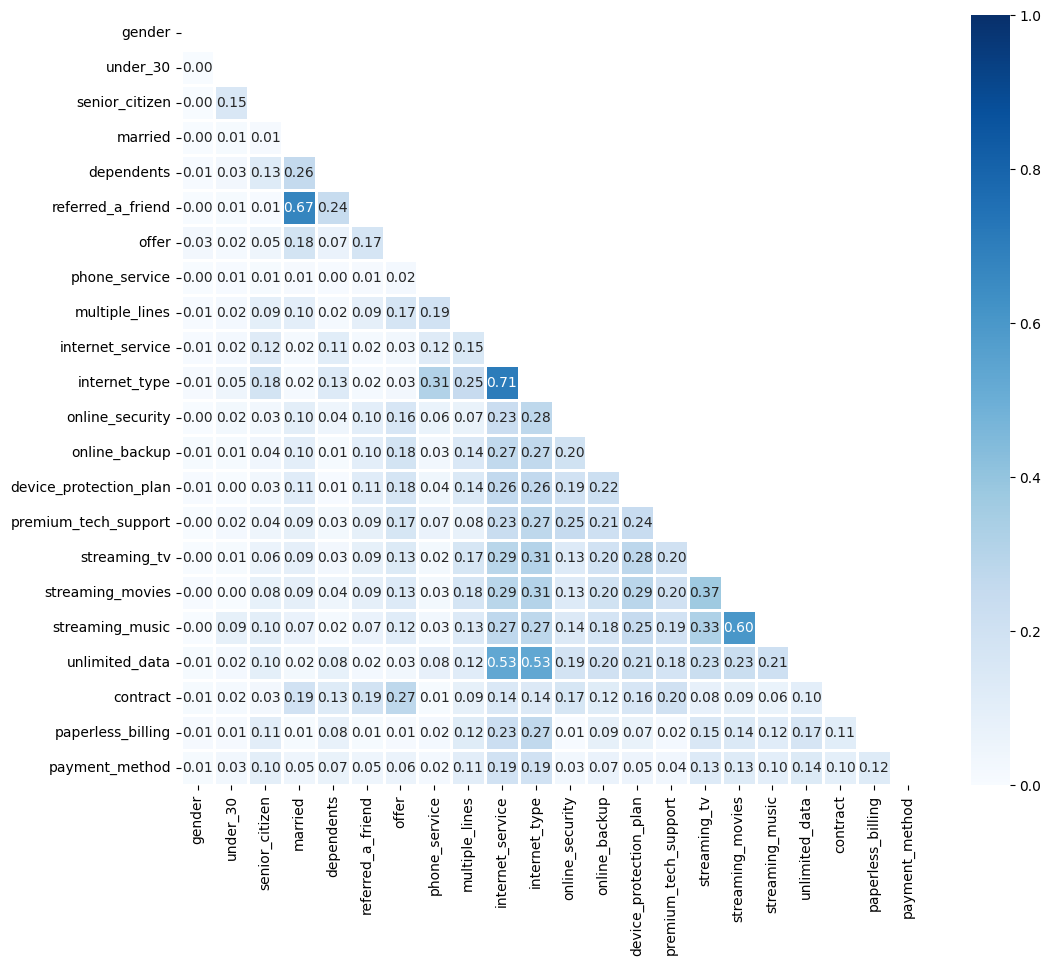

In [41]:
#Matrice de correlation à travers le V de Cramer
cramer_matrix = compute_cramer_v(X_train[cat_cols])

# Visualisations de la matrice du V de Cramer
mask = np.triu(np.ones_like(cramer_matrix))
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    cramer_matrix,
    vmin=0, vmax=1,
    mask=mask,
    annot=True,
    cmap="Blues",
    linewidths=1,
    fmt=".2f",
    ax=ax
)
plt.show()

Nons ne remarquons pas de forte corrélation entre les différentes variables catégorielles. A noter, une liaison plus importante entre `internet_type` et `internet_service` ou `referred_a_friend` et `married`.

Affichons le lien qu'il pourrait exister entre ces variables.

In [42]:
#lien entre internet_type et internet_service
X_train[X_train["internet_service"] == "No"].loc[:, ["internet_type", "internet_service"]].describe()

,internet_type,internet_service
count,1107,1107
unique,1,1
top,None,No
freq,1107,1107


In [43]:
#lien entre referred_a_friend et married
X_train[X_train["referred_a_friend"] == "No"].loc[:, ["referred_a_friend", "married"]].describe()

,referred_a_friend,married
count,2827,2827
unique,1,2
top,No,No
freq,2827,2698


Il existe un lien évident entre ces variables en fonction de la valeur de la variable binaire.

### <font color='#3b4859'>3.3.2 Présélection de variables</font>

La variable `customer_id` nous a été utile pour démontrer l'indépendance des observations. Elle ne sera pas utile pour le modèle parce qu'elle n'est pas interprétable. Nous la supprimons ici pour nos analyse.

In [44]:
y_train = y_train.drop(columns="customer_id")

### <font color='#3b4859'>Encodage des variables catégorielles</font>

### <font color='#3b4859'>a) Présélection univariée</font>

Dans un premier temps nous pouvons présélectionner les variables en définissant un seuil, ce qui nous donnera une règle de décision pour cette présélection.

In [45]:
#@title Coefficient de corrélation de Pearson
pearson_coef = pearson_matrix["churn_value"].apply(np.abs)
pearson_coef = pearson_coef.sort_values(ascending=False).reset_index().rename(columns={"index" : "variable", "churn_value" : "coefficient"})
pearson_coef[1:]

,variable,coefficient
1,tenure_in_months,0.344464
2,number_of_referrals,0.279969
3,total_long_distance_charges,0.220751
4,total_revenue,0.216134
5,number_of_dependents,0.215805
6,monthly_charge,0.195146
7,total_charges,0.191079
8,age,0.125893
9,avg_monthly_gb_download,0.049761
10,options_number,0.028670


Le coefficient de Pearson nous indique la relation linéaire calculée entre deux variables.

Nous pourrions ici retenir les 6 premières variables, `tenure_in_months`, `number_of_referrals`,
 `total_long_distance_charges`,
 `total_revenue`,
 `number_of_dependents` et `monthly_charge`.

 ou

 En appliquant un filtre basé sur le critère du coude nous aurions 8 variables liés à la cible y.
 `tenure_in_months`, `number_of_referrals`,
 `total_long_distance_charges`,
 `total_revenue`,
 `number_of_dependents`, `monthly_charge`,
 `total_charges`et
 `age`.

In [46]:
#@title V de Cramer pour les variables catégorielles
# Construire un dataframe contenant à la fois les coefficients
# du V de Cramer et la p-value associée à chaque variable catégorielle
cramer_matrix = []
for col in cat_cols:
    # Calcule du V de Cramer entre la variable col et y
    cramer_values = cramer_v_coeff(x=X_train[col], y=y_train["churn_value"])
    # Concatenez dans le dictionnaire contenant la variable col,
    # la valeur du V de Cramer et la p-value de significativité
    cramer_matrix.append(
        {
            'features': col,
            'cramer_v': cramer_values[0],
            'p_value':  round(cramer_values[1], 4)
        }
    )

# Transformez la liste de dictionnaires en dataframe
# pour faciliter les manipulations à venir
cramer_matrix = (pd.DataFrame(cramer_matrix)
                 .sort_values(["cramer_v"],ascending=False)
                 .reset_index(drop=True)
                )

# Affichez la matrice
cramer_matrix

,features,cramer_v,p_value
0,contract,0.3179,0.0000
1,internet_type,0.2200,0.0000
2,offer,0.1814,0.0000
3,dependents,0.1753,0.0000
4,internet_service,0.1586,0.0000
5,payment_method,0.1575,0.0000
6,paperless_billing,0.1370,0.0000
7,online_security,0.1191,0.0000
8,premium_tech_support,0.1150,0.0000
9,senior_citizen,0.1120,0.0000


Le V de Cramer nous indique une mesure de la liaison entre une variables catégorielles et la cible.
Nous pourrions retenir les 10 premières variables en fonction de cet indicateur, sur les 22, ce qui nous donnerais `contract`,
 `internet_type`,
 `offer`,
`dependents`,
 `internet_service`,
`payment_method`,
 `paperless_billing`,
 `online_security`,
 `premium_tech_support` et
 `senior_citizen`.

 Alors que si nous utilisions un filtre basé sur le critère du coude nous aurions séléctionné les 13 premières variables.


`contract`,
 `internet_type`,
 `offer`,
`dependents`,
 `internet_service`,
`payment_method`,
 `paperless_billing`,
 `online_security`,
 `premium_tech_support`,
 `senior_citizen`,
 `unlimited_data`,
 `referred_a_friend` et
 `married`.


### <font color='#3b4859'>Filtre sur la variance</font>

Ce filtre nous permet d'éliminer les variables numérique en fonction d'un seuil basé sur la variance.

In [47]:
# Sélection des prédicteurs selon un seuil de 1
nzv_selector = VarianceThreshold(1)
nzv_selector.fit(X_train[num_cols])

# Variance des différentes variables
# les différentes variances peuvent être récupérées à partir de la méthode variances_
features_variances = pd.DataFrame({"features": X_train[num_cols].columns, "variance": nzv_selector.variances_})
features_variances["variance"] = features_variances["variance"].map('{:,.2f}'.format)
print(f"Le tableau de variance :\n{features_variances}\n")

# Récupérez dans une liste les variables sélectionnées
nzv_features = np.array(num_cols)[nzv_selector.get_support()].tolist()
print(f"La liste features avec une variance supérieure au seuil de 1 :\n{nzv_features}")

Le tableau de variance :
                             features      variance
0                                 age        278.60
1                number_of_dependents          0.91
2                 number_of_referrals          8.90
3                    tenure_in_months        603.65
4   avg_monthly_long_distance_charges        237.70
5             avg_monthly_gb_download        420.43
6                      monthly_charge        894.45
7                       total_charges  5,106,115.72
8                       total_refunds         62.96
9            total_extra_data_charges        625.40
10        total_long_distance_charges    707,074.36
11                      total_revenue  8,144,939.64
12                     options_number          5.86

La liste features avec une variance supérieure au seuil de 1 :
['age', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges', 'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_dat

### <font color='#3b4859'>Critère d'information mutuelle</font>

Séléctionnons les variables numériques selon le critère d'information mutuel qui mesure la dépendance entre deux variables.

In [48]:
# Initialisation
mic_selector = SelectKBest(score_func=mutual_info_classif, k=6)

# Entrainement
mic_selector.fit(X_train[num_cols], np.ravel(y_train))

# Liste des variables retenues
mic_features = np.array(num_cols)[mic_selector.get_support()].tolist()
print(f"Variables retenues : {mic_features}")

Variables retenues : ['number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'monthly_charge', 'total_charges', 'total_long_distance_charges']


Nous remarquons ici une différence dans la mesure de dépendance des variables. Pour rappel sur un choix de 6 variables basé sur le coefficient de Pearson nous avions `tenure_in_months`, `number_of_referrals`,
 `total_long_distance_charges`,
 `total_revenue`,
 `number_of_dependents` et `monthly_charge`.

### <font color='#3b4859'>Test du chi2</font>

In [49]:
# One hot encoder sur les variables catégorielles
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(X_train[cat_cols])

# liste des colonnes encodées
enc_columns = one_hot_encoder.get_feature_names_out()

# création d'un dataframe
X_train_enc = pd.DataFrame(
     one_hot_encoded,
     columns=enc_columns
)

In [50]:
# Initialisation
chi2_selector = SelectKBest(score_func=chi2, k=10)

# Entrainement
chi2_selector.fit(
    X=X_train_enc,
    y=y_train
)

# Liste des variables retenues
chi2_features = np.array(enc_columns)[chi2_selector.get_support()].tolist()
print(chi2_features)

['dependents_Yes', 'offer_Offer E', 'internet_service_No', 'internet_type_Fiber Optic', 'internet_type_None', 'contract_Month-to-Month', 'contract_One Year', 'contract_Two Year', 'paperless_billing_No', 'payment_method_Credit Card']


Liste des variables significativement lié à la cible avec 0.05 comme seuil de la p-value.

In [51]:
chi2_p_value_features = np.array(enc_columns)[chi2_selector.pvalues_<0.05].tolist()
print(chi2_p_value_features)

['under_30_Yes', 'senior_citizen_No', 'senior_citizen_Yes', 'married_No', 'married_Yes', 'dependents_No', 'dependents_Yes', 'referred_a_friend_No', 'referred_a_friend_Yes', 'offer_Offer A', 'offer_Offer B', 'offer_Offer E', 'multiple_lines_Yes', 'internet_service_No', 'internet_service_Yes', 'internet_type_DSL', 'internet_type_Fiber Optic', 'internet_type_None', 'online_security_No', 'online_security_Yes', 'online_backup_No', 'online_backup_Yes', 'device_protection_plan_No', 'device_protection_plan_Yes', 'premium_tech_support_No', 'premium_tech_support_Yes', 'streaming_tv_No', 'streaming_tv_Yes', 'streaming_movies_No', 'streaming_movies_Yes', 'streaming_music_Yes', 'unlimited_data_No', 'unlimited_data_Yes', 'contract_Month-to-Month', 'contract_One Year', 'contract_Two Year', 'paperless_billing_No', 'paperless_billing_Yes', 'payment_method_Bank Withdrawal', 'payment_method_Credit Card', 'payment_method_Mailed Check']


### <font color='#3b4859'>b) Présélection multivariée</font>


Nous utiliserons pour notre étude la méthode de sélection de variables RFE (Recursive Feature Elimination).

Dans un premier temps les variables devront être transformées.


*   Encodage des variables catégorielles
*   Normalisation des variables numériques



In [52]:
# Initialisation du standarscaler pour les variables numériques
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

In [53]:
# Créons le preprocesseur avec le ColumnTransformer pour appliquer les transformations sur les colonnes appropriées
preprocessor = ColumnTransformer([
    ("cat", one_hot_encoder, cat_cols),
    ("num", standard_scaler, num_cols),
])
X_train_enc = preprocessor.fit_transform(X_train)

In [54]:
# Récupérons les noms de variables transformées
features_names = preprocessor.get_feature_names_out()

# Mise en place d'un dataframe avec les variables encodées et normalisées
X_train_enc = pd.DataFrame(
     X_train_enc,
     columns=features_names
)

X_train_enc

,cat__gender_Female,cat__gender_Male,cat__under_30_No,cat__under_30_Yes,cat__senior_citizen_No,cat__senior_citizen_Yes,cat__married_No,cat__married_Yes,cat__dependents_No,cat__dependents_Yes,...,num__tenure_in_months,num__avg_monthly_long_distance_charges,num__avg_monthly_gb_download,num__monthly_charge,num__total_charges,num__total_refunds,num__total_extra_data_charges,num__total_long_distance_charges,num__total_revenue,num__options_number
0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,-1.270098,-1.471331,-0.617997,-0.836108,-0.985040,-0.249514,0.526082,-0.875959,-1.032717,-0.430457
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,-0.578175,-0.736447,1.527896,1.029658,-0.227010,5.498678,-0.273662,-0.633427,-0.384058,0.396007
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.195150,-1.060756,-0.325375,0.396033,0.266690,-0.249514,-0.273662,-0.597429,0.033429,-0.843688
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,-1.270098,-0.480243,0.454950,0.193741,-0.971410,-0.249514,-0.273662,-0.857788,-1.023578,-0.843688
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,-0.700280,1.387128,-0.081523,0.327488,-0.495566,-0.249514,-0.273662,-0.089816,-0.420544,-0.843688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5153,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.235852,0.801426,-0.910618,0.161977,0.159197,2.295016,-0.273662,0.707530,0.325734,-0.843688
5154,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.537474,0.445335,-0.374145,0.469594,-0.340942,3.133110,-0.273662,-0.208264,-0.342420,-0.430457
5155,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.619698,0.005572,-1.008159,-1.454686,-0.374443,2.184110,-0.273662,1.073719,0.011414,-1.256920
5156,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.333967,0.866937,0.162328,0.673558,-0.121707,5.828875,-0.273662,0.152966,-0.069898,1.635703


In [55]:
# Définir et instancier le classifieur à entraîner
# On fait le choix d'une forêt aléatoire ici
set_seed = 42
step = 5
estimator = RandomForestClassifier(random_state=set_seed)

# Instanciation de la RFECV()
rfecv_selector = RFECV(estimator=estimator,
                       min_features_to_select=10,
                       scoring='roc_auc',
                       n_jobs=-1,
                       step=step,
                       cv=None
                      )

# Entraînez le modèle
rfecv_selector = rfecv_selector.fit(X_train_enc, np.ravel(y_train))

In [56]:
rfecv_selector.cv_results_["mean_test_score"]

array([0.85381372, 0.87099619, 0.86886439, 0.87256188, 0.87583175,
       0.87188769, 0.87662262, 0.87107214, 0.87059867, 0.87254469,
       0.87631061, 0.87571717])

In [57]:
# Liste des variables issues de RFECV
rfe_features = rfecv_selector.get_feature_names_out()
print(f"Liste des variables transformées conservées par la RFE :\n{rfe_features}\n")

Liste des variables transformées conservées par la RFE :
['cat__gender_Female' 'cat__gender_Male' 'cat__senior_citizen_No'
 'cat__senior_citizen_Yes' 'cat__dependents_No' 'cat__dependents_Yes'
 'cat__referred_a_friend_Yes' 'cat__offer_None' 'cat__multiple_lines_Yes'
 'cat__internet_type_DSL' 'cat__internet_type_Fiber Optic'
 'cat__online_security_No' 'cat__online_security_Yes'
 'cat__device_protection_plan_Yes' 'cat__premium_tech_support_No'
 'cat__premium_tech_support_Yes' 'cat__streaming_tv_Yes'
 'cat__streaming_music_No' 'cat__streaming_music_Yes'
 'cat__unlimited_data_Yes' 'cat__contract_Month-to-Month'
 'cat__contract_One Year' 'cat__contract_Two Year'
 'cat__paperless_billing_No' 'cat__paperless_billing_Yes'
 'cat__payment_method_Bank Withdrawal' 'cat__payment_method_Credit Card'
 'num__age' 'num__number_of_dependents' 'num__number_of_referrals'
 'num__tenure_in_months' 'num__avg_monthly_long_distance_charges'
 'num__avg_monthly_gb_download' 'num__monthly_charge' 'num__total_char

Nous remarquons ici l'importance de certaines modalités présente dans les variables catégorielles. Comme dans `internet_type_Fiber` où les sous catégories DSL et Optic ont été sélectionné, ou encore dans `contract` variable dans laquelle tous les contrats sont sélectionnés.


In [58]:
# Nombre de variables séléctionnées
rfecv_selector.n_features_

40

In [59]:
mean_test_roc_auc = rfecv_selector.cv_results_["mean_test_score"]
# Nombre de variables séléctionnées
n_features_selected = rfecv_selector.n_features_
min_features_to_select = rfecv_selector.min_features_to_select
n_features_in_rfecv = rfecv_selector.n_features_in_



fig = px.line(y=mean_test_roc_auc,
              x=range(min_features_to_select, len(X_train_enc.columns) + step, step),
              labels={
                     "x": "Nombre de variables sélectionnées",
                     "y": "Score moyen de cross-validation"
              },
              title="Résultats RFECV avec 5 k-fold"
             )
fig.add_vline(x=n_features_selected, line_width=3, line_dash="dash", line_color="#3b4859")
fig.add_vrect(x0=30, x1=n_features_in_rfecv, line_width=0, fillcolor="#ff7373", opacity=0.2)
fig.show()

Nous remarquons dans ce graphique une zone stable, en rose, entre 31 et 65 variables. Avec un score optimal à 40.

In [60]:
# Récupérons la liste des variables originales
original_features = X_train.columns.to_list()
features = []
for col in original_features:
  for col_transformed in rfe_features:
    if col in col_transformed:
      features.append(col)
print(f"Liste des {len(set(features))} variables, sur {len(cat_cols) + len(num_cols)} séléctionnées par la RFE :\n {set(features)}")

Liste des 29 variables, sur 35 séléctionnées par la RFE :
 {'internet_type', 'referred_a_friend', 'streaming_tv', 'age', 'senior_citizen', 'dependents', 'total_charges', 'tenure_in_months', 'total_long_distance_charges', 'device_protection_plan', 'streaming_music', 'unlimited_data', 'offer', 'total_extra_data_charges', 'number_of_dependents', 'premium_tech_support', 'total_refunds', 'total_revenue', 'multiple_lines', 'gender', 'number_of_referrals', 'online_security', 'payment_method', 'monthly_charge', 'contract', 'paperless_billing', 'avg_monthly_long_distance_charges', 'options_number', 'avg_monthly_gb_download'}


# <font color='#3b4859'>4. Création et optimisation du modèle</font>

## <font color='#3b4859'>4.1. Préprocessing des données d'évaluation</font>


Les noms des colonnes du jeu de données d'évaluation `X_test` ne correspondent pas à celles d'entrainement `X_train`.
Nous allons donc procéder à une mise à jour.

In [61]:
train_col = X_train.drop('options_number', axis=1).columns.to_list()

In [62]:
test_col = X_test.columns.to_list()

In [63]:
# fonction de remplacement du nommage des colonnes pour avoir une liste de noms de variables équivalent entre les deux jeux de données
def columns_train_test(list1, list2):
  for col1 in list1:
    for col2 in list2:
      if col2 in col1 and len(col2.split("_")) == len(col1.split("_")):
        X_test.rename(columns ={col1 : col2}, inplace=True)
      else:
        pass

columns_train_test(test_col, train_col)
test_col = X_test.columns.to_list()

In [64]:
# Vérification
test_col == train_col

True

In [65]:
# Création de la variable nombre d'options
X_test["options_number"] = X_test[options].apply(lambda x: options_number(x), axis = 1)

In [66]:
# Suppression de la colonne id
def drop_id(df):
  df.drop("customer_id", axis = 1, inplace = True)

drop_id(X_train)
drop_id(X_test)

## <font color='#3b4859'>4.2. Pipeline de transformation</font>

Dans cette partie nous allons utiliser l'échantillon de train pour entrainer les différents modèles. Cependant un échantillon de validation sera également mis de côté afin d'avoir une première estimation des capacités du modèle avant de le mettre en pratique sur l'échantillon d'évaluation.

In [67]:
# split des données en train et validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=set_seed)

In [68]:
# Définition de fonction pour fitter les modèles
def fit_model(X, y, estimator, **kwargs):

    # séparer les colonnes en numérique et catégorielles
    num_cols = X.select_dtypes(include=np.number).columns
    cat_cols = X.select_dtypes(exclude=np.number).columns

    # Preprocessing des variables : imputation, encodage et normalisation
    # Traitement des variables numériques
    num_pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        standard_scaler
    )
    # Traitement des variables catégorielles
    cat_pipeline = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OneHotEncoder(handle_unknown='ignore')
    )
    # Combinaison des deux pipelines
    preprocessor = ColumnTransformer([
        ("num",num_pipeline, num_cols),
        ("cat",cat_pipeline, cat_cols)
    ])
    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("estimator", estimator)
        ]
    )

    return model.fit(X, np.ravel(y), **kwargs)

# Évaluation du modèle
def model_evaluation(model, X__train, y__train, X__test, y__test):
    # Prédiction sur le jeu de données test
    y_train_pred = model.predict_proba(X__train)
    y_test_pred = model.predict_proba(X__test)
    # Calcul de l'AUC
    auc_train = roc_auc_score(y__train, y_train_pred[:,1])
    auc_test = roc_auc_score(y__test, y_test_pred[:,1])
    return auc_train, auc_test

In [69]:
# Liste des modèles à entraîner
models = {

    "LogisticRegression": LogisticRegression(max_iter=500, random_state=set_seed),

    "BaggingClassifier": BaggingClassifier(n_estimators=30, random_state=set_seed),

    "RandomForestClassifier": RandomForestClassifier(n_estimators=400, max_depth=3, random_state=set_seed),

    "XGBClassifier":
    XGBClassifier(
        n_estimators=80,
        eval_metric='logloss',
        random_state=set_seed
    ),

    "lgbmClassifier" : LGBMClassifier(n_estimators=100, n_jobs=5, random_state=set_seed)
}

# Fit sur chacun des modèles
for model_name, model in models.items():

    # Entrainement du modèle
    fit_m = fit_model(X_train, y_train, model)

    # AUC du train et du test
    evaluation = model_evaluation(fit_m, X_train, y_train, X_val, y_val)
    print(f"AUC {model_name} : {round(evaluation[0], 4)} (train set)",
          f"{round(evaluation[1], 4)} (validation set)"
         )

AUC LogisticRegression : 0.9025 (train set) 0.913 (validation set)


AUC BaggingClassifier : 1.0 (train set) 0.8791 (validation set)
AUC RandomForestClassifier : 0.8859 (train set) 0.8945 (validation set)
AUC XGBClassifier : 0.9996 (train set) 0.8991 (validation set)
AUC lgbmClassifier : 0.9953 (train set) 0.9063 (validation set)


Nous allons maintenant évaluer les modèles avec la liste de variables préselectionnées avec la méthode RFE.

In [70]:
# Suppression des doublons
features = list(dict.fromkeys(features))
# Instancions une variable avec les colonnes préselectionnées
X_train_prepro = X_train[features]
X_val_prepro = X_val[features]
X_test_prepro = X_test[features]

In [71]:
# Fit sur chacun des modèles
for model_name, model in models.items():

    # Entrainement du modèle
    fit_m_prepro = fit_model(X_train_prepro, y_train, model)

    # AUC du train et du test
    evaluation_prepro = model_evaluation(fit_m_prepro, X_train_prepro, y_train, X_val_prepro, y_val)
    print(f"AUC {model_name} : {round(evaluation_prepro[0], 4)} (train set)",
          f"{round(evaluation_prepro[1], 4)} (validation set)"
         )

AUC LogisticRegression : 0.901 (train set) 0.9113 (validation set)
AUC BaggingClassifier : 1.0 (train set) 0.8841 (validation set)
AUC RandomForestClassifier : 0.8886 (train set) 0.8973 (validation set)
AUC XGBClassifier : 0.9997 (train set) 0.9008 (validation set)
AUC lgbmClassifier : 0.9949 (train set) 0.9045 (validation set)


Deux modèles se distinguent ici,

*   **La régression logistique**

      Le modèle semble plutôt adapté à la généralisation, du fait de l'augmentation de son score.
*   **Le light GBM**

    Celui-ci reste sur de bonnes performance malgrès la chute du score entre le jeu de train et le jeu de validation.

Cependant, nous allons séléctionner pour la suite du projet le modèle de light GBM. Ce dernier est robuste aux outliers et la séléction des hyperparamètres nous permettra de trouver un modèle résistant à l'over fitting.



## <font color='#3b4859'>4.3. Optimisation du modèle</font>


Dans cette partie nous allons comparer les différentes valeurs d'hyperparamètres du modèle. Nous utiliserons pour cela une **randomized-search**. Le modèle sera entrainé et évalué sur des données de validation pour chaque combinaisons d'hyperparamètres.

Les paramètres retenus sont ceux indiqués dans la documentation pour réduire le risque d'over-fitting.
https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html#tune-parameters-for-the-leaf-wise-best-first-tree

In [72]:
# dictionnaire des hyperparamètres
params_grid = {'max_bin': [100, 175, 255], #max number of bins that feature values will be bucketed in
              'num_leaves': [11, 21, 31],
              'max_depth': [3, 5, 6], #limit the max depth for tree model
              'bagging_fraction': [0.1, 0.3, 0.6, 1.0], #Use bagging
              'bagging_freq': [1, 2, 3, 5],
              'feature_fraction': [0.8, 1.0], #LightGBM will randomly select a subset of features on each iteration (tree)
              'extra_trees': [False, True] #use extremely randomized trees
             }

# Instanciation du classifieur
lgbm_estimator = LGBMClassifier(n_jobs=5, random_state=set_seed)

# Recherche de la meilleure combinaison d'hyperparamètres
grid_search = RandomizedSearchCV(
    estimator=lgbm_estimator,
    param_distributions=params_grid,
    scoring = 'roc_auc',
    random_state=set_seed,
    n_iter=20,
    n_jobs = -1,
    cv=5,
    verbose=2
)

# Entrainement du modèle
lgbm_model = fit_model(X=X_train_prepro, y=y_train, estimator=grid_search)

# Évaluation du modèle
evaluation = model_evaluation(lgbm_model, X_train_prepro, y_train, X_val_prepro, y_val)
print(evaluation)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
(0.9253561749745185, 0.9160275104500827)


L'optimisation est visible sur l'AUC, avec un score sur l'échantillon de train proche de celui de la validation. Et également une amélioration du score sur l'échantillon de validation.

In [73]:
# Liste des hyperparamètres sélectionnés
grid_search.best_params_

{'num_leaves': 21,
 'max_depth': 3,
 'max_bin': 255,
 'feature_fraction': 1.0,
 'extra_trees': True,
 'bagging_freq': 1,
 'bagging_fraction': 0.6}

# <font color='#3b4859'>5. évaluation et explicativité des modèles</font>

## <font color='#3b4859'>5.1. Courbe de lift</font>


Observons la surconcentration de la population cible avec la courbe de lift.

<Figure size 800x800 with 0 Axes>

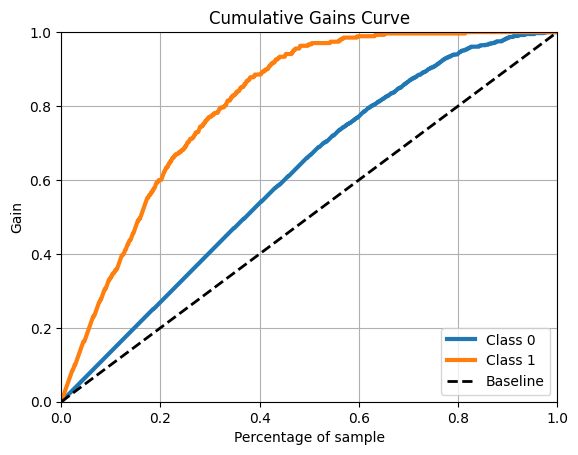

In [74]:
# Courbe de lift avec scikitplot
!pip install scikit-plot
import scikitplot as skplt
plt.figure(figsize=(8,8))
skplt.metrics.plot_cumulative_gain(
    y_true=y_val,
    y_probas=lgbm_model.predict_proba(X_val_prepro)
)
plt.show()

## <font color='#3b4859'>5.2. Score de spiegelhalter</font>


Nous allons évaluer le modèle sélectionné et hyperparamètrisé sur les données de validation.

In [75]:
# Prédire sur le jeu de validation
y_pred = lgbm_model.predict_proba(X_val_prepro)[:, 1]

Nous allons ici évaluer la calibration avec les scores de spiegelhalter.

L'interpretation se fait comme suit :

- $ 0 \leq \lvert SH \rvert \leq 1$ : bonne calibration
- $ 1 \lt \lvert SH \rvert \leq 2$ : calibration médiocre
- $ \lvert SH \rvert \gt 2$ : mauvaise calibration

In [76]:
# Fonction du calcul du score
def score_spiegelhalter(y_true, y_pred):
    numerateur = np.sum(np.multiply(y_true - y_pred, 1 - 2 * y_pred))
    denominateur = np.sqrt(
        np.sum(
            np.multiply(
                np.multiply(np.power(1 - 2 * y_pred, 2), y_pred), 1 - y_pred
            )
        )
    )

    return numerateur / denominateur

In [77]:
spigelhalter = score_spiegelhalter(np.ravel(y_val), y_pred)
print(f"Le score absolu est de {round(abs(spigelhalter),2)}.")

Le score absolu est de 0.43.


Le score indique une bonne calibration.

Par la suite, nous allons visualiser la courbe de calibration pour avoir une interprétation différente de ce score.

## <font color='#3b4859'>5.3. Courbe de calibration</font>


In [78]:
from sklearn.calibration import calibration_curve

# La fonction de sklearn calcule les probabilités de vrais postifs et de positifs prédits pour tracer ensuite une courbe de calibration.

bins = 20
prob_true, prob_pred = calibration_curve(
        y_val, y_pred,
        n_bins=bins,
        strategy="quantile"
    )

calibration_plots = pd.DataFrame({"prob_pred":prob_pred, "prob_true":prob_true})

# Représentation graphique
xlim_ylim_sklearn = calibration_plots.values.max()

fig = px.scatter(
    calibration_plots,
    x="prob_pred",
    y="prob_true"
)
fig.add_trace(
    go.Scatter(
        x=[0, xlim_ylim_sklearn],
        y=[0, xlim_ylim_sklearn],
        mode="lines",
        line=go.scatter.Line(color="gray"),
        showlegend=False)
)
fig.update_layout(
    xaxis_title="Moyenne des probabilités prédites",
    yaxis_title="Proportion des positifs (y = 1)",
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    margin=dict(l=0, r=0, t=30, b=50),
    width=600, height=600
)
fig.show()

La courbe indique une bonne calibration, à remarquer un léger décrochage sur les valeurs de y proches de 0 et autour de 0,25.
Dans ce dernier cas, le modèle a tendance à prédire moins de  positifs ou autrement il a une plus faible probabilité de prédire un positif.

## <font color='#3b4859'>5.4. Importance des variables</font>


Dans un premier temps nous récupérons dans le pipeline de transformation le meilleur modèle trouvé avec la *randomized-search* via l'objet `estimator`.

In [79]:
# pipeline -> noms des steps -> choix de l'objet 'estimator' -> attribut best_estimator_ de la RandomizedSearchCV
lgbm_model_selected = lgbm_model.named_steps.estimator.best_estimator_

Avec l'attribut *feature_importances_* que nous retrouvons dans la documentation de lightgbm, nous pouvons afficher l'importance  des variables.

https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier

In [80]:
feature_importances = lgbm_model_selected.feature_importances_

Ensuite avec l'attribut `get_feature_names_out()`, nous affichons les noms des variables précédentes via le `preprocessor`.


In [81]:
# liste des colonnes encodées
feature_names = lgbm_model.named_steps.preprocessor.get_feature_names_out()

Nous pouvons ensuite les afficher sous la forme d'un dataframe.

In [82]:
# création d'un dataframe
feature_importances_df = pd.DataFrame({"variable" : feature_names, "importance" : feature_importances}).sort_values(["importance"], ascending=False).reset_index(drop=True)
# affichons les 10 premières
feature_importances_df.head(10)

,variable,importance
0,num__number_of_referrals,52
1,cat__contract_Month-to-Month,38
2,num__tenure_in_months,33
3,num__monthly_charge,29
4,cat__referred_a_friend_No,28
5,cat__dependents_No,28
6,cat__senior_citizen_No,24
7,num__total_revenue,23
8,cat__payment_method_Credit Card,22
9,cat__internet_type_Fiber Optic,22


Visualisons les 20 premières variables avec un graphique de barplots.

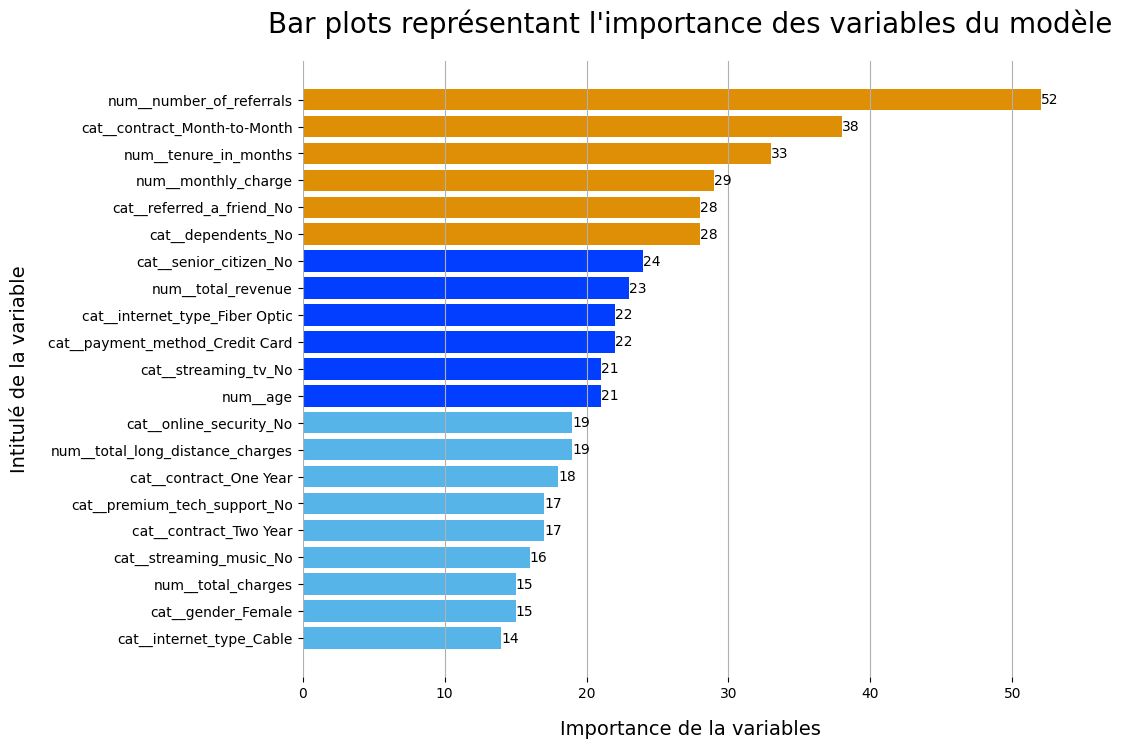

In [83]:
#@title Visualisation des variables du modèle par importance

feature_importances_viz = feature_importances_df.loc[:20,:].copy()
feature_importances_viz.sort_values(["importance"], ascending=True, inplace=True)

mean_score = (feature_importances_df["importance"].sum()/feature_importances_df["importance"].count())

# couleurs
clrs = ['#DE8F05' if (x >= 25) else '#56B4E9' if (x < 20 ) else '#023EFF' for x in feature_importances_viz['importance']]

# Iniatilisation du graphique
fig, ax = plt.subplots(figsize = (10,8))
hbars = ax.barh(y=feature_importances_viz["variable"], width=feature_importances_viz["importance"], color=clrs)
ax.bar_label(hbars)

#Ajout des labels sur les axes
ax.set_ylabel("Intitulé de la variable",
             fontsize = 14,
             labelpad = 14)
ax.set_xlabel("Importance de la variables",
             fontsize = 14,
             labelpad =14)
ax.set_title("Bar plots représentant l'importance des variables du modèle",
            fontsize = 20,
            pad = 20)

# affichage d'une grille sur l'axis x
ax.grid(visible=True, which='major', axis='x')
# clear des bordures pour plus de visibilité
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [84]:
df[df["churn_value"] == 1]["number_of_referrals"].describe()

count    1359.000000
mean        0.522443
std         1.121836
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         9.000000
Name: number_of_referrals, dtype: float64

In [85]:
df[df["churn_value"] == 0]["number_of_referrals"].describe()

count    3799.000000
mean        2.418268
std         3.269144
min         0.000000
25%         0.000000
50%         0.000000
75%         5.000000
max        11.000000
Name: number_of_referrals, dtype: float64

Au vu de ces résultats, et de nos analyses statistiques, la variable `number_of_referrals` qui concerne le nombre de parainnages ou de recommandations du client influence plus fortement le modèle que les autres variables. Dans l'analyse univariée nous avions constaté la relation entre la résiliation et la faible quantité de *referrals*. Cette variable influance notre modèle dans ce sens.

A noter également,


*   `contract` et la catégorie month-to-month, c'est à dire les clients qui sont engagés mensuellement.
*   `tenure_in_months`, connote la durée cumulée d'engagement et la fidélité du client.
*   `monthly_charge`, le prix d'une mensualité élevée augmente la fragilité du client.
*   `referred_a_friend`, le fait de ne pas avoir parrainé un ami ou de la famille.
*   `dependents`, un client vivant seul est un facteur de résiliation.



➜ évaluation et explicativité des modèles : courbe de ROC, courbe de lift, courbe
de calibration, importance des variables, les graphiques de SHAP . . .

In [86]:
 !pip list command

Package                   Version
------------------------- --------
asttokens                 2.2.1
attrs                     23.1.0
backcall                  0.2.0
comm                      0.1.3
contourpy                 1.1.0
cycler                    0.11.0
decorator                 5.1.1
executing                 1.2.0
fastjsonschema            2.17.1
fonttools                 4.40.0
ipykernel                 6.23.3
ipython                   8.14.0
jedi                      0.18.2
joblib                    1.3.1
jsonschema                4.18.0
jsonschema-specifications 2023.6.1
jupyter_client            8.3.0
jupyter_core              5.3.1
kiwisolver                1.4.4
lightgbm                  3.3.5
matplotlib                3.7.1
matplotlib-inline         0.1.6
nbformat                  5.9.0
nest-asyncio              1.5.6
numpy                     1.22.4
packaging                 23.1
pandas                    1.5.3
parso                     0.8.3
pickleshare             